##### As part of the collabration in a team, I will use CNN model to classify 3 categories of images 

lighting, dew, blaze

1. Read Images from each classes 
2. Explore the type, shapes, color distributions of the each images 
and calculate the distribution of means of each images form each classes of images and comapre the uniformity

4. Split Train vs Test Dataset

5. Image Preprocessing 

https://www.section.io/engineering-education/image-preprocessing-in-python/#:~:text=There%20are%20several%20techniques%20used,to%20grayscale%2C%20and%20image%20augmentation.
    
- resize 
- converting images to grayscale
- Normalisation & Standardization
- Data Augmentation
- Image standardization
- shiftting, reversing, and rotation and flipping on each train image to increase variance of the data sampel to generlate models 


### ImageDataGenerator

https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
- Use from tensorflow.keras.preprocessing.image import ImageDataGenerator to Preprocess the image data


In [1]:
import tensorflow 
from tensorflow import keras  
import os
import glob 

from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import random 
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd

import skimage
from skimage import data, io, filters, color, exposure
from skimage.transform import rotate

from skimage import data, io, filters, feature
from skimage.color.colorconv import rgb2grey
from skimage.transform import resize

import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import model_from_yaml


from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance
from tqdm import tqdm
from sklearn.metrics import accuracy_score

%matplotlib inline



In [2]:
import PIL
  
print('Installed Pillow Version:', PIL.__version__)

Installed Pillow Version: 8.4.0


### Read Images from each classes and Label the df

In [3]:
weather_classes = ["lightning", "dew", "glaze"]
path_imgs_classes = {}
for i in weather_classes:
    path = 'dataset' + "/" + i +'/*.jpg'
#     print(path)
#     print(glob.glob(path))

    path_imgs_classes[i]= (list(glob.glob(path)))

In [4]:
lightning_imgs = path_imgs_classes["lightning"]
dew_imgs = path_imgs_classes["dew"]
glaze_imgs = path_imgs_classes["glaze"]


In [5]:
# load each class of image into a dataframe 

weather_data = pd.DataFrame()

for i in weather_classes:
    
    path_imgs = path_imgs_classes[i]
    labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
    file_path = pd.Series(path_imgs, name='File_Path').astype(str)
    labels = pd.Series(labels, name='Labels')
    data = pd.concat([file_path, labels], axis=1)
    data = data.sample(frac=1).reset_index(drop=True)
    
    
    weather_data = pd.concat([weather_data, data], axis=0)

weather_data = weather_data.reset_index()[['File_Path','Labels']]
# class_num = dict(zip(list(weather_data.Labels.unique()), [1,2,3] ))

conditions = [
    (weather_data['Labels'] == 'lightning'),
    (weather_data['Labels'] == 'dew') ,
    (weather_data['Labels'] == 'glaze') 
    ]

# create a list of the values we want to assign for each condition
values = [1, 2, 3]

# create a new column and use np.select to assign values to it using our lists as arguments
weather_data ['weather_classes'] = np.select(conditions, values)

# display updated DataFrame
weather_data.head()

,File_Path,Labels,weather_classes
0,dataset/lightning/1888.jpg,lightning,1
1,dataset/lightning/1907.jpg,lightning,1
2,dataset/lightning/1896.jpg,lightning,1
3,dataset/lightning/2127.jpg,lightning,1
4,dataset/lightning/2033.jpg,lightning,1


In [6]:
weather_data.shape

(1714, 3)

In [7]:
weather_data.Labels.unique()

array(['lightning', 'dew', 'glaze'], dtype=object)

In [8]:
for i in list(weather_data.weather_classes.unique()):
    print(i)
    print(weather_data[weather_data['weather_classes'] == i].shape)

1
(377, 3)
2
(698, 3)
3
(639, 3)


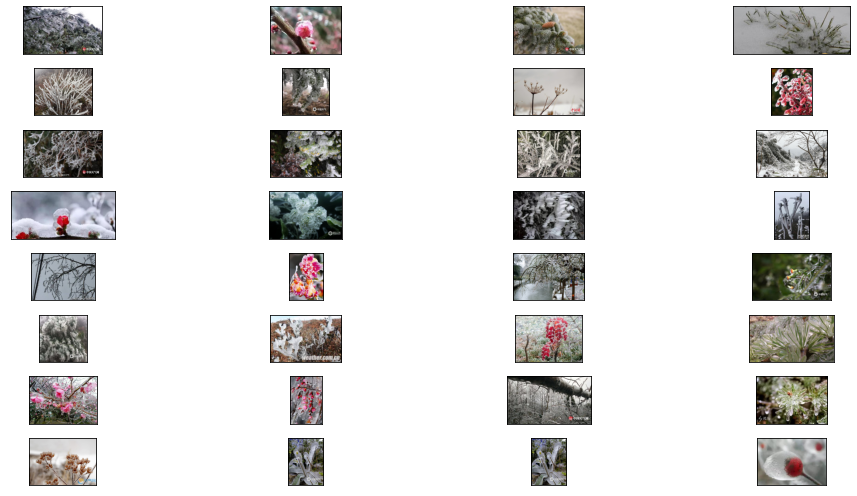

In [9]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(weather_data[weather_data["Labels"] == 'glaze'].reset_index().File_Path[i]))
#     ax.set_title(weather_data.Labels[i])
plt.tight_layout()
plt.show()

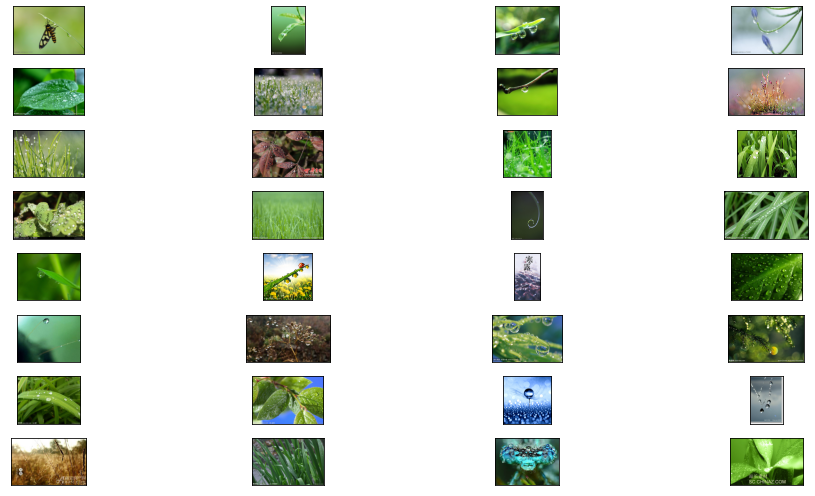

In [10]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(weather_data[weather_data["Labels"] == 'dew'].reset_index().File_Path[i]))
#     ax.set_title(weather_data.Labels[i])
plt.tight_layout()
plt.show()

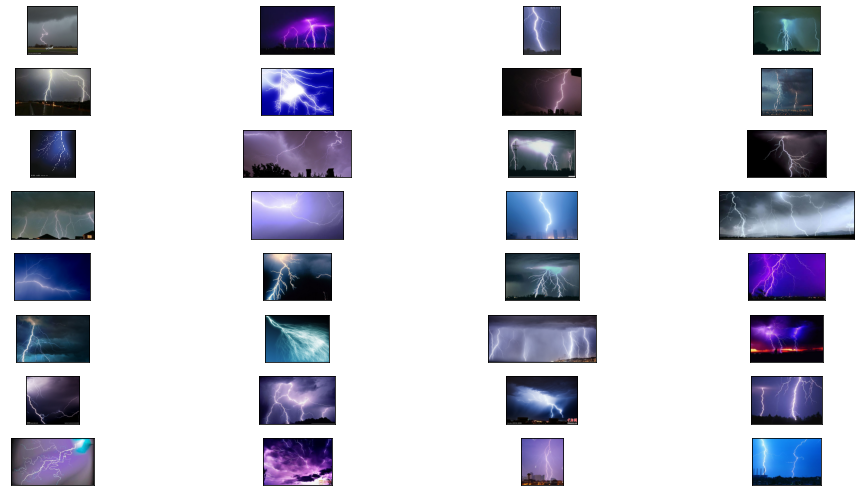

In [11]:
# read each jpg files image and into dataframe colummn called "Images"

fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(weather_data[weather_data["Labels"] == 'lightning'].File_Path[i]))
#     ax.set_title(weather_data.Labels[i])
plt.tight_layout()
plt.show()



### calculate stats on each images and EDA

In [12]:
def lighting_histogram_plotting(imag_data):
    for col, channel in zip('rgb', np.rollaxis(imag_data , axis=-1)):
        hist, bin_centers = exposure.histogram(channel)
        plt.fill_between(bin_centers, hist, color=col, alpha=0.4)
    plt.title('lighting Histogram', fontsize=15)
    plt.show()

In [13]:
# convert image into numpy array:
# https://www.geeksforgeeks.org/how-to-convert-images-to-numpy-array/

from PIL import Image
from numpy import asarray
  
#   sample.png is the name of the image
# file and assuming that it is uploaded
# in the current directory or we need
# to give the path

## summarize some details about the image
# print(image.format)
# print(image.size)
# print(image.mode)

img_mean_val = []
img_median_val = []
img_shape_val = []
img_colors = []


for path in weather_data.File_Path :
#     print(path)
    image = Image.open(path)
    # convert image into numpy array
    numpydata = asarray(image)
#     print(image)

    img_mean_val.append(numpydata.mean())
    img_median_val.append(np.median(numpydata))
    img_shape_val.append(numpydata.shape)

    # gather the colors of the images:
    color_dicts = dict(zip('rgb', np.rollaxis(numpydata , axis=-1)))
    img_colors.append(tuple(color_dicts.keys()))


weather_data['img_mean_val'] = img_mean_val
weather_data['img_median_val'] = img_median_val
weather_data['img_shape_val'] = img_shape_val
weather_data['img_colors'] = img_colors


def multiple_yourself(object_items):
    res = 1
    for i in object_items:

        res = res * i 

    return res

size_amount_val = []
for i in weather_data['img_shape_val']:
    size_amount_val.append(multiple_yourself(i)/1000 )
    
weather_data["imag_matrix_size(per 1000)"] = size_amount_val
  

In [14]:
weather_data.head(15)

,File_Path,Labels,weather_classes,img_mean_val,img_median_val,img_shape_val,img_colors,imag_matrix_size(per 1000)
0,dataset/lightning/1888.jpg,lightning,1,94.456315,92.0,"(595, 624, 3)","(r, g, b)",1113.840
1,dataset/lightning/1907.jpg,lightning,1,56.511858,26.0,"(180, 280, 3)","(r, g, b)",151.200
2,dataset/lightning/1896.jpg,lightning,1,106.647239,96.0,"(316, 247, 3)","(r, g, b)",234.156
3,dataset/lightning/2127.jpg,lightning,1,69.966893,66.0,"(283, 400, 3)","(r, g, b)",339.600
4,dataset/lightning/2033.jpg,lightning,1,80.603274,75.0,"(253, 400, 3)","(r, g, b)",303.600
5,dataset/lightning/1980.jpg,lightning,1,131.221684,155.0,"(160, 245, 3)","(r, g, b)",117.600
6,dataset/lightning/2172.jpg,lightning,1,47.124102,33.0,"(186, 309, 3)","(r, g, b)",172.422
7,dataset/lightning/1950.jpg,lightning,1,80.428345,72.0,"(1469, 1595, 3)","(r, g, b)",7029.165
8,dataset/lightning/1975.jpg,lightning,1,49.045694,30.0,"(1200, 1141, 3)","(r, g, b)",4107.600
9,dataset/lightning/1886.jpg,lightning,1,101.941965,105.0,"(501, 1142, 3)","(r, g, b)",1716.426


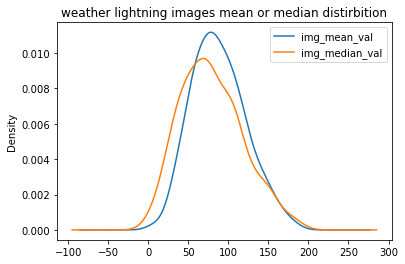

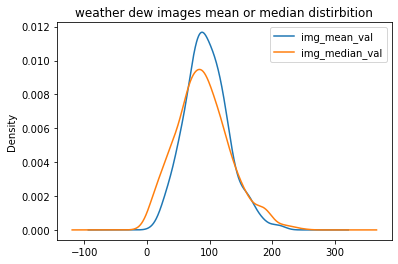

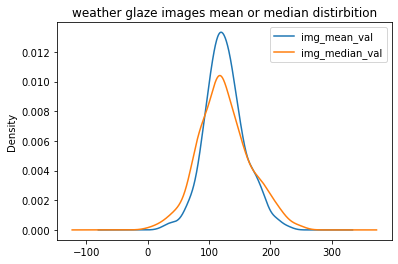

In [15]:
for weather_item in ['lightning', 'dew', 'glaze']:
    s_df = weather_data[weather_data['Labels'] == weather_item][['img_mean_val', 'img_median_val']]

    ax = s_df.plot.kde(title ="weather {} images mean or median distirbition".format(weather_item))
#     ax.title("weather {} images mean distirbition".format(weather_item))

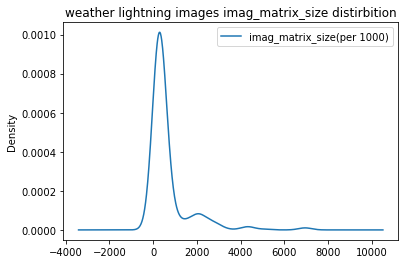

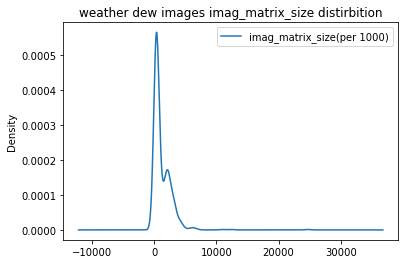

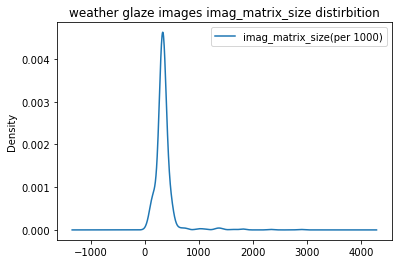

In [16]:
for weather_item in ['lightning', 'dew', 'glaze']:
    s_df = weather_data[weather_data['Labels'] == weather_item][['imag_matrix_size(per 1000)']]

    ax = s_df.plot.kde(title ="weather {} images imag_matrix_size distirbition".format(weather_item))

Read and preProcess Images into X an y

In [68]:

def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.6,1.4))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.6,1.4))
    image = np.array(image)/255.0
    return image


def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(128,128))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

In [69]:
x_train_paths = []
y_train_paths = []
x_val_paths = []
y_val_paths = []

all_paths = []
all_labels = []
data_dir = 'dataset/'
dir_types = ['dew', 'lightning', 'glaze']

# split train and test 80 :20

for label in dir_types:
    for image in os.listdir(data_dir+label):
        all_paths.append(data_dir+label+'/'+image)
        all_labels.append(label)

# pick a good amount of data to do 80/20 train split test IE, 1710 * 0.2 = 342 + 4 = 346 test dataset 
rest_paths, rest_labels = all_paths[1711:], all_labels[1711:] # take out the last 4 samples aside, layter get joined with test set 
all_paths, all_labels = all_paths[:1711], all_labels[:1711] # take the first 1710 amount of data for 80/20 split

all_paths_train_test_split, all_labels_train_test_split = shuffle(all_paths, all_labels)
train_index = int(0.8 * len(all_paths_train_test_split) +1 )
# print(train_index)
x_train_paths = all_paths_train_test_split[:train_index-1]
y_train = all_labels_train_test_split[:train_index-1]
x_test_paths = all_paths_train_test_split[train_index-1:] + rest_paths
y_test = all_labels_train_test_split[train_index-1:] + rest_labels

# save the images from the train set into later train set evaluation
x_test_val_paths = all_paths_train_test_split[train_index-1:] + rest_paths
y_test_val_paths = all_labels_train_test_split[train_index-1:] + rest_labels

print(len(x_train_paths))
print(len(y_train))

print(len(x_test_paths))
print(len(y_test))

# print(len(x_train_val_paths))
# print(len(y_test_vals_paths))


1368
1368
346
346


In [ ]:
# # remove all the files from folders 

# def remove_files(file_lst):
    
#     for filePath in file_lst:
#         if os.path.exists(filePath):
#             os.remove(filePath)
#         else:
#             print("Can not delete the file as it doesn't exists")


# filePaths = [list(glob.glob("dataset/dataset_test/*.jpg")),
#         list(glob.glob("dataset/dataset_train/lightning/*.jpg")),
#         list(glob.glob("dataset/dataset_train/rainbow/*.jpg")),
#         list(glob.glob("dataset/dataset_train/fog/*.jpg")),
#         list(glob.glob("dataset/dataset_train/glaze/*.jpg")),
#         list(glob.glob("dataset/dataset_test/lightning/*.jpg")),
#         list(glob.glob("dataset/dataset_test/rainbow/*.jpg")),
#         list(glob.glob("dataset/dataset_test/fog/*.jpg")),
#         list(glob.glob("dataset/dataset_test/glaze/*.jpg"))
#     ]

# for file_lst in filePaths:
#     remove_files(file_lst)

In [ ]:
# create Train and test set folder for data
# import shutil
# for src2 in x_test_paths:
#     shutil.copy(src2, 'dataset/dataset_test')
    

In [ ]:
# import shutil
# for src2 in x_test_paths:
#     if "lightning" in src2:
#         shutil.copy( src2, "dataset/dataset_test/lightning")
#     elif "dew" in src2:
#         shutil.copy( src2, "dataset/dataset_test/dew")
#     else:
#         shutil.copy( src2, "dataset/dataset_test/glaze")

In [ ]:
# create Train and test set folder for data 

# for src in x_train_paths:
#     if "lightning" in src:
#         shutil.copy( src, "dataset/dataset_train/lightning")
#     elif "dew" in src:
#         shutil.copy( src, "dataset/dataset_train/dew")
#     else:
#         shutil.copy( src, "dataset/dataset_train/glaze")
    

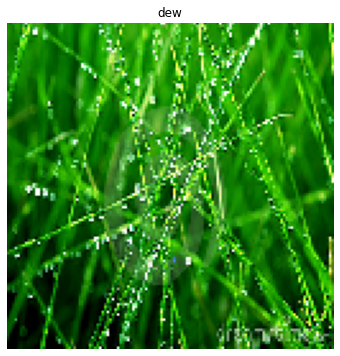

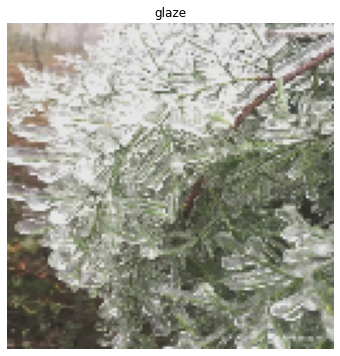

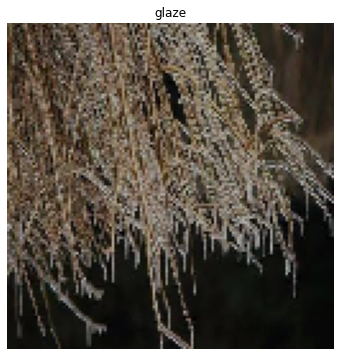

In [20]:
num_images = 3
images = open_images(x_train_paths[:num_images])

for x in range(0, num_images):
#     fig.add_subplot(2,4, x)
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.title(y_train[x])
    plt.imshow(images[x])
    plt.show()

In [70]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True)

# build training dataset generator
path = "/Users/mikewu/Desktop/UChicago/Winter 2022/ML and Predictive Modeling/Final Project/dataset/dataset_train"
target_size = (128, 128)
batch_size = 2
class_mode = 'categorical'

train_generator = train_datagen.flow_from_directory(
    directory = path,
    color_mode="rgb",
    target_size = target_size,
    class_mode = class_mode,   
    batch_size = batch_size,  
    shuffle=True,
    seed=42
)

# check category labels
print(train_generator.class_indices)
# print(y_test)

Found 1368 images belonging to 3 classes.
{'dew': 0, 'glaze': 1, 'lightning': 2}


In [71]:
valid_generator = train_datagen.flow_from_directory(
    directory="/Users/mikewu/Desktop/UChicago/Winter 2022/ML and Predictive Modeling/Final Project/dataset/dataset_train",
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=2,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 1368 images belonging to 3 classes.


In [72]:
test_generator = train_datagen.flow_from_directory(
    directory="/Users/mikewu/Desktop/UChicago/Winter 2022/ML and Predictive Modeling/Final Project/dataset/dataset_test",
  target_size=(128, 128),
    color_mode="rgb",
    batch_size=2,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 346 images belonging to 3 classes.


In [73]:
unique_labels = os.listdir('dataset/dataset_train')
def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)


def data_gen(paths, labels, batch_size=12):
    
    if len(paths)!=len(labels):
        raise Exception('The length of paths is ',len(paths), ' but the length of labels is ', len(labels))
    
    for x in range(0, len(paths), batch_size):
        batch_paths = paths[x:x+batch_size]
        batch_images = open_images(batch_paths)
        batch_labels = labels[x:x+batch_size]
        batch_labels = encode_label(batch_labels)
        yield batch_images, batch_labels

### ResNet Transfer learning model 

Resnet has been trained on thousdand of hundreds of imges before

Without training the model with a train set, use a resNet pretrained CNN model to directly apply to the test set of images and identify each image and get the accuracy as part of the model exploratiary analysis 

In [128]:
from tensorflow.keras.applications import resnet50, densenet
from tensorflow.keras.preprocessing import image

model = resnet50.ResNet50()
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [129]:
# print(x_test_paths)
print(y_test)

['glaze', 'glaze', 'lightning', 'dew', 'dew', 'glaze', 'dew', 'glaze', 'glaze', 'dew', 'dew', 'glaze', 'dew', 'dew', 'dew', 'lightning', 'glaze', 'dew', 'lightning', 'dew', 'lightning', 'dew', 'glaze', 'dew', 'glaze', 'dew', 'lightning', 'glaze', 'glaze', 'glaze', 'lightning', 'dew', 'dew', 'lightning', 'glaze', 'dew', 'dew', 'dew', 'lightning', 'lightning', 'dew', 'dew', 'lightning', 'glaze', 'lightning', 'glaze', 'dew', 'dew', 'glaze', 'dew', 'glaze', 'glaze', 'glaze', 'dew', 'dew', 'dew', 'dew', 'dew', 'lightning', 'dew', 'dew', 'dew', 'glaze', 'dew', 'glaze', 'dew', 'dew', 'glaze', 'glaze', 'dew', 'glaze', 'dew', 'glaze', 'lightning', 'dew', 'glaze', 'dew', 'lightning', 'dew', 'glaze', 'glaze', 'glaze', 'dew', 'dew', 'glaze', 'glaze', 'glaze', 'dew', 'dew', 'glaze', 'glaze', 'glaze', 'lightning', 'lightning', 'glaze', 'dew', 'dew', 'lightning', 'lightning', 'glaze', 'dew', 'glaze', 'lightning', 'dew', 'lightning', 'lightning', 'glaze', 'dew', 'dew', 'glaze', 'dew', 'lightning', 'gl

In [141]:
result_reNet = {}
for i in range(0, len(x_test_paths)):
    
#     print(x_test_paths[i])
    # Load the image file, resizing it to 224x224 pixels (required by this model)
    img = image.load_img( x_test_paths[i], target_size=(224, 224) )
    #img = image.load_img("images/timessq.jpg", target_size=(224, 1000))

#     plt.imshow(img)

    # Convert the image to a numpy array
    x = image.img_to_array(img)

    # Add a forth dimension since Keras expects a list of images
    x = np.expand_dims(x, axis=0)
    
    # Scale the input image to the range used in the trained network
    x = resnet50.preprocess_input(x)

    # Run the image through the deep neural network to make a prediction
    predictions = model.predict(x)

    # Look up the names of the predicted classes. Index zero is the results for the first image.
    predicted_classes = resnet50.decode_predictions(predictions, top=6)

#     print("This is an image of:")
    
    names = []
    likelihoods = []

    for imagenet_id, name, likelihood in predicted_classes[0]:
        names.append(name)
        likelihoods.append(likelihood)
    
    # capture predicted top names, likelihood and true label fo each image
    result_reNet[x_test_paths[i]] = [names, likelihoods, y_test[i]]
    

In [142]:
# compare against the true label if the top 3 prediction class matches the true label and how many was correctly predicted ?
dew_list = []
glaze_list = []
lightening_list = []
for i in result_reNet.values():
    if "dew" in i:
        dew_list = dew_list  + i[0]
    elif "glaze" in i:
        glaze_list = glaze_list  + i[0]
    
    else:
        lightening_list = lightening_list  + i[0]
        
dew_lst = list(set(dew_list))
glaze_lst = list(set(glaze_list))
lightening_lst = list(set(lightening_list ))
        


In [147]:
frequency_dew = {}
for item in dew_lst:
    frequency_dew[item] = dew_list.count(item)
frequency_dew = {k: v for k, v in sorted(frequency_dew.items(), key=lambda item: item[1], reverse=True)}
print("Frequency of items: ", frequency_dew)


Frequency of items:  {'spider_web': 32, 'bubble': 31, 'ant': 30, 'leafhopper': 25, 'leaf_beetle': 25, 'ladybug': 24, 'lycaenid': 21, 'cucumber': 18, 'damselfly': 18, 'lacewing': 15, 'dragonfly': 14, 'tree_frog': 14, 'head_cabbage': 14, 'fountain': 12, 'cabbage_butterfly': 12, 'green_snake': 12, 'daisy': 10, 'hummingbird': 10, 'garden_spider': 10, 'Granny_Smith': 9, 'broccoli': 9, 'cricket': 9, 'weevil': 9, 'grasshopper': 9, 'shower_curtain': 9, 'indigo_bunting': 8, 'walking_stick': 8, 'vine_snake': 8, 'limpkin': 8, 'snail': 8, "yellow_lady's_slipper": 7, 'acorn': 7, 'harvestman': 7, 'tick': 7, 'mushroom': 7, 'water_bottle': 7, 'black_and_gold_garden_spider': 6, 'slug': 6, 'screw': 6, 'pot': 6, 'bittern': 6, 'bee': 6, 'coil': 6, 'cardoon': 5, 'hip': 5, 'mantis': 5, 'wolf_spider': 5, 'sulphur_butterfly': 5, 'strawberry': 5, 'reel': 4, 'European_gallinule': 4, 'rapeseed': 4, 'pinwheel': 4, 'fig': 4, 'nail': 4, 'ringlet': 4, 'American_chameleon': 4, 'fly': 4, 'sea_urchin': 4, 'crane': 4, '

In [148]:

frequency_glaze = {}
for item in glaze_lst:
    frequency_glaze[item] = glaze_list.count(item)
frequency_glaze = {k: v for k, v in sorted(frequency_glaze.items(), key=lambda item: item[1], reverse=True)}
print("Frequency of items: ", frequency_glaze)


Frequency of items:  {'coral_fungus': 40, 'hip': 37, 'picket_fence': 27, 'spider_web': 25, 'cliff': 20, 'chainlink_fence': 18, 'fountain': 17, 'coral_reef': 17, 'alp': 16, 'pot': 16, 'birdhouse': 15, 'hummingbird': 13, 'barn': 13, 'park_bench': 13, 'bee': 11, 'great_grey_owl': 10, 'stone_wall': 10, 'hen-of-the-woods': 9, 'lakeside': 8, 'valley': 8, 'strawberry': 8, 'bannister': 7, 'cardoon': 7, 'greenhouse': 7, 'vase': 7, 'swab': 6, 'nail': 6, 'trifle': 6, 'garden_spider': 6, 'sulphur_butterfly': 6, 'ant': 6, 'earthstar': 6, 'tick': 6, 'ladybug': 6, 'monarch': 5, 'isopod': 5, 'barn_spider': 5, 'brambling': 5, 'knot': 5, 'plastic_bag': 5, 'cabbage_butterfly': 5, 'thatch': 5, 'black_grouse': 5, 'ski': 5, 'bald_eagle': 5, 'sea_anemone': 5, 'volcano': 5, 'sea_urchin': 5, 'chain_saw': 4, 'indigo_bunting': 4, 'jellyfish': 4, 'worm_fence': 4, 'magpie': 4, 'sea_slug': 4, 'megalith': 4, 'stole': 4, 'acorn': 4, 'house_finch': 4, 'ringlet': 4, 'lorikeet': 4, 'web_site': 4, 'pole': 4, 'mushroom': 

In [149]:
frequency_lightening = {}
for item in lightening_lst:
    frequency_lightening[item] = lightening_list.count(item)
frequency_lightening = {k: v for k, v in sorted(frequency_lightening.items(), key=lambda item: item[1], reverse=True)}
print("Frequency of items: ", frequency_lightening)



Frequency of items:  {'fountain': 49, 'geyser': 43, 'volcano': 38, 'stage': 27, 'spotlight': 24, 'spider_web': 20, 'monitor': 18, 'alp': 14, 'missile': 12, 'space_shuttle': 10, 'fireboat': 9, 'jellyfish': 7, 'oscilloscope': 7, 'beacon': 6, 'torch': 6, 'garden_spider': 6, 'loudspeaker': 6, 'theater_curtain': 5, 'church': 5, 'shower_curtain': 5, 'matchstick': 4, 'cliff': 4, 'screen': 4, 'microphone': 4, 'television': 4, 'pole': 4, 'valley': 3, 'barn': 3, 'cannon': 3, 'black_and_gold_garden_spider': 3, 'projectile': 3, 'traffic_light': 3, 'dock': 2, 'breakwater': 2, 'ashcan': 2, 'beer_glass': 2, 'parachute': 2, 'steam_locomotive': 2, 'bucket': 2, 'sax': 2, 'desktop_computer': 2, 'barn_spider': 2, 'castle': 1, 'promontory': 1, 'boathouse': 1, 'killer_whale': 1, 'lakeside': 1, 'seashore': 1, 'goblet': 1, 'balloon': 1, 'digital_clock': 1, 'grey_whale': 1, 'caldron': 1, 'mountain_tent': 1, 'notebook': 1, 'cash_machine': 1, 'vase': 1, 'abaya': 1, 'gown': 1, 'barrel': 1, 'drilling_platform': 1,

### Start a basic CNN Model as a Baseline

In [89]:
#------------ build a CNN from scratch by imitating vgg16


model = Sequential()
model.add(Conv2D(input_shape=(128, 128 ,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4, activation="softmax"))

from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.00001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

model.save_weights("saved_models/new_initial_weights.h5")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 32, 32, 256)      

In [105]:
batch_size=4
epochs=6
steps = int(len(x_train_paths)/batch_size/epochs)
steps
# train for 8-12 epochs
for _ in range(epochs):
    model.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), epochs=epochs, steps_per_epoch=steps)


Train for 57 steps
Epoch 1/6
57/57 [==============================] - 160s 3s/step - loss: 0.5724 - accuracy: 0.7939
Epoch 2/6
57/57 [==============================] - 163s 3s/step - loss: 0.5559 - accuracy: 0.7851
Epoch 3/6
57/57 [==============================] - 165s 3s/step - loss: 0.4304 - accuracy: 0.8816
Epoch 4/6
57/57 [==============================] - 167s 3s/step - loss: 0.4793 - accuracy: 0.8202
Epoch 5/6
57/57 [==============================] - 166s 3s/step - loss: 0.5206 - accuracy: 0.8158
Epoch 6/6
57/57 [==============================] - 164s 3s/step - loss: 0.3647 - accuracy: 0.8640
Train for 57 steps
Epoch 1/6
57/57 [==============================] - 171s 3s/step - loss: 0.3904 - accuracy: 0.8684
Epoch 2/6
57/57 [==============================] - 224s 4s/step - loss: 0.4437 - accuracy: 0.8289
Epoch 3/6
57/57 [==============================] - 215s 4s/step - loss: 0.4301 - accuracy: 0.8640
Epoch 4/6
57/57 [==============================] - 200s 4s/step - loss: 0.4488 -

In [107]:
filename = 'normal_cnn'
model_yaml = model.to_yaml()
with open("saved_models/" + filename + ".yaml", 'w') as yaml_file: 
    yaml_file.write(model_yaml)
weights_file = "saved_models/" + filename + ".h5"
model.save_weights(weights_file)
print("Model saved to disk")

Model saved to disk


In [ ]:
steps = int(len(x_val_paths)/batch_size)

In [111]:
len(x_test_paths)/2

173.0

In [112]:
batch_size=2
steps = int(len(x_test_paths)/batch_size)

y_pred_model = []
y_true_model = []

for x,y in tqdm(data_gen(x_test_paths, y_test, batch_size=batch_size), total=steps):
    pred_model = model.predict(x)
    pred_model = np.argmax(pred_model, axis=-1)
    for i in pred_model:
        y_pred_model.append(i)
    for i in y:
        y_true_model.append(i)

100%|██████████| 173/173 [01:53<00:00,  1.52it/s]


In [122]:
print(y_pred_model)

[1, 1, 0, 3, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 0, 1, 3, 0, 3, 0, 3, 1, 3, 1, 3, 0, 1, 1, 3, 0, 3, 3, 0, 1, 3, 3, 3, 1, 0, 3, 1, 0, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 0, 0, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 0, 3, 1, 3, 0, 3, 1, 1, 1, 3, 3, 1, 1, 1, 0, 3, 1, 1, 1, 0, 0, 1, 3, 3, 0, 0, 1, 1, 1, 0, 3, 0, 0, 1, 3, 3, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 3, 1, 1, 1, 1, 3, 3, 0, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 0, 0, 1, 1, 1, 1, 3, 1, 0, 1, 0, 1, 0, 1, 3, 3, 0, 1, 3, 3, 1, 1, 1, 0, 1, 1, 3, 1, 1, 3, 0, 1, 0, 1, 1, 1, 1, 3, 3, 3, 1, 3, 0, 1, 0, 3, 0, 3, 3, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 0, 3, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 1, 3, 0, 1, 0, 1, 3, 3, 1, 3, 3, 3, 3, 0, 1, 1, 0, 1, 1, 0, 1, 3, 1, 0, 0, 1, 1, 0, 0, 1, 3, 1, 3, 3, 3, 1, 1, 0, 3, 1, 1, 1, 0, 3, 1, 1, 3, 0, 3, 1, 1, 0, 3, 0, 3, 3, 3, 3, 1, 3, 0, 0, 1, 1, 0, 0, 1, 3, 0, 1, 1, 1, 3, 3, 1, 3, 3, 1, 0, 1, 1, 1, 1, 1, 3, 3, 0, 3, 0, 3, 1, 3, 1, 0, 0, 1, 3, 1, 0, 3, 1, 1, 1, 

In [123]:
print(y_true_model)

[1, 1, 0, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 0, 1, 3, 0, 3, 0, 3, 1, 3, 1, 3, 0, 1, 1, 1, 0, 3, 3, 0, 1, 3, 3, 3, 0, 0, 3, 3, 0, 1, 0, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 0, 3, 1, 3, 0, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 0, 0, 1, 3, 3, 0, 0, 1, 3, 1, 0, 3, 0, 0, 1, 3, 3, 1, 3, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 3, 1, 1, 1, 1, 3, 3, 0, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 0, 3, 1, 1, 3, 3, 1, 0, 1, 1, 1, 0, 3, 3, 3, 0, 1, 3, 3, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 0, 1, 0, 1, 1, 0, 3, 3, 3, 1, 1, 3, 0, 1, 0, 3, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 0, 3, 3, 3, 1, 3, 1, 3, 0, 1, 3, 3, 0, 3, 1, 1, 3, 0, 3, 1, 1, 1, 3, 3, 0, 3, 3, 3, 0, 1, 0, 3, 3, 3, 1, 3, 3, 3, 3, 0, 1, 1, 3, 1, 1, 0, 1, 3, 1, 0, 0, 1, 1, 0, 0, 1, 3, 1, 3, 3, 3, 1, 0, 0, 3, 1, 1, 0, 0, 3, 1, 1, 3, 0, 3, 1, 3, 1, 3, 0, 3, 3, 3, 3, 1, 3, 0, 0, 3, 3, 0, 0, 1, 3, 0, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 0, 3, 0, 3, 1, 3, 1, 0, 0, 1, 3, 1, 0, 3, 1, 1, 3, 

In [115]:
print(classification_report(y_true_model, y_pred_model))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        70
           1       0.82      0.94      0.88       139
           3       0.96      0.80      0.87       137

    accuracy                           0.88       346
   macro avg       0.89      0.89      0.88       346
weighted avg       0.89      0.88      0.88       346



test if the model is over/under-fitting 

In [117]:
# apply on train set 
batch_size=4
epochs=6
steps = int(len(x_train_paths)/batch_size/epochs)
y_pred_train_model = []
y_true_train_model = []

for x,y in tqdm(data_gen(x_train_paths, y_train, batch_size=batch_size), total=steps):
    pred_model = model.predict(x)
    pred_model = np.argmax(pred_model, axis=-1)
    for i in pred_model:
        y_pred_train_model.append(i)
    for i in y:
        y_true_train_model.append(i)

342it [07:20,  1.29s/it]                       


In [118]:
print(classification_report(y_true_train_model, y_pred_train_model))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       307
           1       0.83      0.96      0.89       500
           3       0.96      0.81      0.88       561

    accuracy                           0.89      1368
   macro avg       0.89      0.90      0.89      1368
weighted avg       0.90      0.89      0.89      1368



as we can see that our CNN model is not over/underfitting when compare the train or test set performances

### Implement pre-train Nueral Networks on the Image Processing 

VGG16

In [51]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

# load the model
vgg16 = VGG16(input_shape=(128, 128,3), include_top=False, weights='imagenet')

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [52]:
model_vgg16 = Sequential()
model_vgg16.add(Input(shape=(128, 128, 3)))
model_vgg16.add(vgg16)
model_vgg16.add(Flatten())
model_vgg16.add(Dropout(0.3))
model_vgg16.add(Dense(768, activation='relu'))
model_vgg16.add(Dropout(0.25))
model_vgg16.add(Dense(256, activation='relu'))
model_vgg16.add(Dropout(0.25))
model_vgg16.add(Dense(4, activation='softmax'))
model_vgg16.summary()

model_vgg16.compile( loss = 'sparse_categorical_crossentropy',
#     loss = 'categorical_crossentropy', 
              optimizer =keras.optimizers.Adam(learning_rate=0.0001), 
              metrics = ["accuracy"])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 768)               6292224   
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               196864    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

In [53]:
# steps_per_epochs = 32
# epochs = 50

# vgg_history = run_model(steps_per_epoch= steps_per_epochs,epochs = epochs, CNN_model= model_vgg16, model_output_name = "vgg16_cnn" , run_epochs=False )

batch_size=12
steps = int(len(x_train_paths)/batch_size)
epochs=1 # train for 8-12 epochs
for _ in range(epochs):
    model_vgg16.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), epochs=1, steps_per_epoch=steps)



Train for 114 steps
114/114 [==============================] - 819s 7s/step - loss: 0.5262 - accuracy: 0.8107


In [55]:
filename = 'vgg16_cnn'
model_yaml = model.to_yaml()
with open("saved_models/" + filename + ".yaml", 'w') as yaml_file: 
    yaml_file.write(model_yaml)
weights_file = "saved_models/" + filename + ".h5"
model_vgg16.save_weights(weights_file)
print("Model saved to disk")

Model saved to disk


result preduction label: lighting: 0, dew = 3, glaze = 1

In [57]:
batch_size=12
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []

for x,y in tqdm(data_gen(x_test_paths, y_test, batch_size=batch_size), total=steps):
    pred = model_vgg16.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(i)
    for i in y:
        y_true.append(i)


29it [01:42,  3.55s/it]


In [124]:
print(y_pred)

[3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 0, 1, 1, 0, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 0, 0, 1, 3, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 0, 3, 3, 0, 1, 1, 3, 3, 1, 0, 1, 3, 3, 1, 1, 1, 1, 1, 0, 0, 0, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 0, 0, 3, 1, 0, 1, 1, 3, 1, 3, 0, 3, 1, 1, 0, 0, 3, 0, 0, 1, 0, 1, 0, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 0, 3, 3, 1, 0, 1, 3, 3, 0, 3, 1, 1, 1, 0, 1, 1, 0, 3, 0, 1, 0, 3, 1, 0, 3, 1, 3, 0, 0, 3, 0, 0, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 0, 3, 3, 1, 0, 1, 1, 3, 0, 1, 1, 3, 1, 0, 1, 3, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 0, 3, 1, 3, 0, 1, 0, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 0, 1, 1, 1, 1, 0, 3, 1, 0, 3, 3, 3, 0, 0, 1, 3, 0, 0, 0, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 0, 1, 1, 3, 3, 1, 0, 3, 1, 3, 1, 3, 3, 3, 3, 0, 1, 1, 0, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 0, 0, 3, 3, 0, 1, 1, 0, 3, 1, 0, 3, 0, 3, 3, 0, 1, 3, 3, 1, 0, 3, 1, 0, 1, 3, 3, 1, 0, 3, 3, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 3, 1, 0, 0, 

In [154]:
print(y_true)

[3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 0, 0, 0, 0, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 0, 0, 1, 3, 0, 1, 1, 3, 1, 3, 1, 1, 1, 1, 0, 0, 3, 3, 0, 1, 1, 3, 3, 1, 0, 1, 3, 3, 3, 1, 1, 1, 3, 0, 0, 0, 1, 3, 1, 0, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 0, 0, 3, 1, 0, 1, 1, 3, 1, 3, 0, 3, 1, 1, 0, 0, 3, 0, 0, 1, 0, 1, 0, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 0, 3, 3, 1, 0, 1, 3, 1, 0, 3, 1, 1, 1, 0, 3, 1, 0, 3, 0, 1, 0, 3, 1, 0, 3, 1, 3, 0, 3, 3, 0, 0, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 0, 3, 3, 3, 0, 1, 1, 3, 0, 3, 1, 3, 1, 0, 1, 3, 3, 0, 1, 1, 1, 0, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 3, 0, 3, 1, 3, 0, 1, 0, 1, 3, 1, 3, 3, 3, 3, 0, 1, 1, 3, 3, 0, 1, 1, 1, 1, 0, 3, 1, 0, 3, 3, 3, 0, 0, 1, 3, 0, 0, 0, 1, 3, 3, 1, 1, 1, 1, 3, 3, 0, 3, 3, 0, 1, 1, 3, 3, 1, 0, 3, 1, 3, 3, 3, 3, 3, 3, 0, 1, 1, 0, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 0, 0, 3, 3, 0, 1, 1, 0, 3, 1, 0, 3, 0, 3, 3, 0, 1, 3, 3, 1, 0, 3, 1, 0, 1, 3, 3, 1, 0, 3, 3, 1, 1, 1, 1, 1, 0, 1, 3, 0, 1, 1, 3, 0, 3, 1, 0, 0, 

In [153]:
print(y_test)

['glaze', 'glaze', 'lightning', 'dew', 'dew', 'glaze', 'dew', 'glaze', 'glaze', 'dew', 'dew', 'glaze', 'dew', 'dew', 'dew', 'lightning', 'glaze', 'dew', 'lightning', 'dew', 'lightning', 'dew', 'glaze', 'dew', 'glaze', 'dew', 'lightning', 'glaze', 'glaze', 'glaze', 'lightning', 'dew', 'dew', 'lightning', 'glaze', 'dew', 'dew', 'dew', 'lightning', 'lightning', 'dew', 'dew', 'lightning', 'glaze', 'lightning', 'glaze', 'dew', 'dew', 'glaze', 'dew', 'glaze', 'glaze', 'glaze', 'dew', 'dew', 'dew', 'dew', 'dew', 'lightning', 'dew', 'dew', 'dew', 'glaze', 'dew', 'glaze', 'dew', 'dew', 'glaze', 'glaze', 'dew', 'glaze', 'dew', 'glaze', 'lightning', 'dew', 'glaze', 'dew', 'lightning', 'dew', 'glaze', 'glaze', 'glaze', 'dew', 'dew', 'glaze', 'glaze', 'glaze', 'dew', 'dew', 'glaze', 'glaze', 'glaze', 'lightning', 'lightning', 'glaze', 'dew', 'dew', 'lightning', 'lightning', 'glaze', 'dew', 'glaze', 'lightning', 'dew', 'lightning', 'lightning', 'glaze', 'dew', 'dew', 'glaze', 'dew', 'lightning', 'gl

In [155]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95        76
           1       0.85      0.98      0.91       130
           3       0.99      0.88      0.93       140

    accuracy                           0.93       346
   macro avg       0.94      0.93      0.93       346
weighted avg       0.94      0.93      0.93       346



If the vgg16 model is over/underfitting 

In [64]:
# apply on train set 
batch_size=12
steps = int(len(x_val_paths)/batch_size)
y_pred_train_model = []
y_true_train_model = []

for x,y in tqdm(data_gen(x_train_paths, y_train, batch_size=batch_size), total=steps):
    pred_model = model_vgg16.predict(x)
    pred_model = np.argmax(pred_model, axis=-1)
    for i in pred_model:
        y_pred_train_model.append(i)
    for i in y:
        y_true_train_model.append(i)

114it [06:49,  3.59s/it]


In [65]:
print(classification_report(y_true_train_model, y_pred_train_model))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       301
           1       0.78      0.98      0.87       509
           3       0.97      0.77      0.86       558

    accuracy                           0.88      1368
   macro avg       0.91      0.89      0.89      1368
weighted avg       0.90      0.88      0.88      1368



the vgg16 transfer learning model is a little underfitted since the model is alittle underperformanced when apply to the train set when compare to the the test set

## Compare CNN vs Vgg16 Transfer Learning Model 

CNN that imitates Vgg16 model as baseline model provide a pretty good performaning classification predictions by showing steady evaluation that are over 87%-91% in accruacy and f-1 score in both train set and test set 

Vgg16 transfer learning model does have a little underfitting issue (space for improvement). However, vgg16 model does display bettern accuracy (88%-93%) and f1 score result (86-95%)


In [ ]:
model model_vgg16

In [ ]:
cnn_model_label = {"glaze": 1, "lightning": 0, "dew":  3}
vgg16_model_label = {"glaze": 1, "lightning": 0, "dew":  3}